In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import OneHotEncoder, Binarizer, LabelEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing, model_selection, metrics
import lightgbm as lgb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from tqdm import tqdm_notebook
from bayes_opt import BayesianOptimization

color = sns.color_palette()
%matplotlib inline

#pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 9999

lgbr = LGBMRegressor()

In [2]:
%%time
#May be skipped! all data can be readed from Data/train_X, test_X, train_y

# Read and preprocessing the data
train_df = pd.read_csv("Data/train.csv", parse_dates=['date1'])
test_df = pd.read_csv("Data/test.csv", parse_dates=['date1'])

# remove unused in test data columns and convert data to days from 01/01/2015
train_df = train_df.drop(['start_square', 'plan_s', 'plan_m', 'plan_l', 'vid_0', 'vid_1', 'vid_2'], axis=1)
train_df['date1_year'] = train_df['date1'].dt.year
train_df['date1_month'] = train_df['date1'].dt.month
train_df['date1'] = (train_df['date1'] - pd.Timestamp('2015-01-01')).dt.days

test_df['date1_year'] = test_df['date1'].dt.year
test_df['date1_month'] = test_df['date1'].dt.month
test_df['date1'] = (test_df['date1'] - pd.Timestamp('2015-01-01')).dt.days

# bulk_id that exist in train and in test
common_bulk_id = list(set(train_df['bulk_id'].unique()) & set(test_df['bulk_id'].unique()))
# new id for easy separate series
train_df['bulk_spalen_id'] = train_df['bulk_id'] + '_' + train_df['spalen'].map(str)
test_df['bulk_spalen_id'] = test_df['bulk_id'] + '_' + test_df['spalen'].map(str)

# getting unique values
unique_df = train_df.nunique().reset_index()
unique_df.columns = ["col_name", "unique_count"]
constant_features = unique_df[unique_df["unique_count"]==1]['col_name'].tolist()

# drop constant features
train_df = train_df.drop(constant_features + ['id'], axis=1)
test_df = test_df.drop(constant_features + ['id'], axis=1)

# so 'bulk_id' will be encoded as label and other features will OneHot
le_bulk = LabelEncoder()
le_bulk.fit(train_df['bulk_id'].append(test_df['bulk_id']))

# handling cat features
cat_features = train_df.columns[train_df.dtypes == 'object'].drop(['bulk_id', 'bulk_spalen_id'])

train_df = pd.get_dummies(train_df, columns=cat_features)
test_df = pd.get_dummies(test_df, columns=cat_features)

print("Train rows and columns : ", train_df.shape)
print("Test rows and columns : ", test_df.shape)

# save train and test data
#train_X.to_csv('Data/train_X.csv', index=False)
#test_X.to_csv('Data/test_X.csv', index=False)
#train_y.tofile('Data/train_y.csv', sep = ',')

Train rows and columns :  (8716, 57)
Test rows and columns :  (1770, 56)
Wall time: 439 ms


In [3]:
%%time
def FeatureCreation(data, create_date_features = False):
    ''' добавляет регрессионные признаки, определяет выходные и праздничные дни'''
    K_back = 5 # на сколько месяцев назад добавлять признаки
    Months_forward = 3
    
    df = data.copy(deep = True)
    T = len(df) + 1

    # добавляем sin и cos признаки
    #for k in range(1, K+1):
    #    df['s' + str(k)] = [np.sin(i * 2 * np.pi * k / period) for i in range(1, T)]
    #    df['c' + str(k)] = [np.cos(i * 2 * np.pi * k / period) for i in range(1, T)]
    
    # кол-во поездок в это же время k_hour часов назад
    for k_month in range (1, K_back + 1):
        df[str(k_month) + '_back'] = df.value.shift(k_month)
        df[str(k_month) + '_price_back'] = df.price.shift(k_month)
        df[str(k_month) + '_ip_back'] = df['Cтавка по ипотеке'].shift(k_month)
        df[str(k_month) + '_kurs_back'] = df['Курс'].shift(k_month)
        df = df.fillna(df.mean())
    
    df['mean'] = df.value.mean()
    df['std'] = df.value.std()
    df['min'] = df.value.min()
    df['max'] = df.value.max()
    df['sum'] = df.value.sum()
    df['cumsum'] = df.value.cumsum()
    
    df['price_mean'] = df.price.mean()
    df['price_std'] = df.price.std()
    df['price_min'] = df.price.min()
    df['price_max'] = df.price.max()
    df['price_sum'] = df.price.sum()
    df['price_cumsum'] = df.price.cumsum()
    
    df['fl_mean'] = df.mean_fl.mean()
    df['fl_std'] = df.mean_fl.std()
    df['fl_min'] = df.mean_fl.min()
    df['fl_max'] = df.mean_fl.max()
    df['fl_sum'] = df.mean_fl.sum()
    df['fl_cumsum'] = df.mean_fl.cumsum()
    
    df['sq_mean'] = df.mean_sq.mean()
    df['sq_std'] = df.mean_sq.std()
    df['sq_min'] = df.mean_sq.min()
    df['sq_max'] = df.mean_sq.max()
    df['sq_sum'] = df.mean_sq.sum()
    df['sq_cumsum'] = df.mean_sq.cumsum()
    
    df['ip_mean'] = df['Cтавка по ипотеке'].mean()
    df['ip_std'] = df['Cтавка по ипотеке'].std()
    df['ip_min'] = df['Cтавка по ипотеке'].min()
    df['ip_max'] = df['Cтавка по ипотеке'].max()
    df['ip_sum'] = df['Cтавка по ипотеке'].sum()
    df['ip_cumsum'] = df['Cтавка по ипотеке'].cumsum()
    
    df['kurs_mean'] = df['Курс'].mean()
    df['kurs_std'] = df['Курс'].std()
    df['kurs_min'] = df['Курс'].min()
    df['kurs_max'] = df['Курс'].max()
    df['kurs_sum'] = df['Курс'].sum()
    df['kurs_cumsum'] = df['Курс'].cumsum()
    
    df['rep1_mean'] = df['Вклады до 1 года'].mean()
    df['rep1_std'] = df['Вклады до 1 года'].std()
    df['rep1_min'] = df['Вклады до 1 года'].min()
    df['rep1_max'] = df['Вклады до 1 года'].max()
    df['rep1_sum'] = df['Вклады до 1 года'].sum()
    df['rep1_cumsum'] = df['Вклады до 1 года'].cumsum()
    
    df['inv_price'] = 100000.0/df.price
    df['inv_kurs'] = 100.0/df['Курс']
    df['inv_ip'] = 100.0/df['Cтавка по ипотеке']
    
    df['flat_price'] = df.price * df.mean_sq

    return df

# merge train and test to count previous values for 12 months
common_df = train_df.append(test_df, ignore_index=True)
bulks = np.unique(common_df.bulk_spalen_id)
ind = train_df.index

key_features = ['spalen', 'value', 'date1', 'date1_month', 'date1_year']
rez_df = []
train_length = len(train_df)

for bulk in tqdm_notebook(bulks):
    rez = common_df[(common_df.bulk_spalen_id == bulk)]
    rez_df.append(FeatureCreation(rez))
    #print(rez)
    #plt.plot(rez.date1, rez.value)
summary_df = rez_df[0].append([rez_df[i] for i in range (1,len(rez_df))])

train_X = summary_df.loc[ind].drop(['value', 'bulk_spalen_id'], axis = 1).fillna(0)
test_X = summary_df.drop(ind).drop(['value', 'bulk_spalen_id'], axis = 1).fillna(0)
#train_X = summary_df.loc[ind].drop(['value', 'bulk_id'], axis = 1).fillna(0)
#test_X = summary_df.drop(ind).drop(['value', 'bulk_id'], axis = 1).fillna(0)
train_y = summary_df.loc[ind]['value'].values

test_X.sort_index(inplace = True)

# save train and test data
train_X.to_csv('Data/train_X.csv', index=False)
test_X.to_csv('Data/test_X.csv', index=False)
train_y.tofile('Data/train_y.csv', sep = ',')

summary_df.to_csv('Data/summary_df.csv', index=False)
print(train_X.shape)
print(test_X.shape)

HBox(children=(IntProgress(value=0, max=941), HTML(value='')))


(8716, 121)
(1770, 121)
Wall time: 1min 38s


In [4]:
# read the data if previous cell was skipped ;)
train_X = pd.read_csv("Data/train_X.csv")
test_X = pd.read_csv("Data/test_X.csv")
train_y = np.fromfile('Data/train_y.csv', sep = ',')

summary_df = pd.read_csv("Data/summary_df.csv")
summary_df.tail()

,Cтавка по ипотеке,bulk_id,bulk_spalen_id,date1,date1_month,date1_year,mean_fl,mean_sq,month,month_cnt,price,spalen,value,Автомойка_да,Автомойка_нет,Вентлияция,Видеонаблюдение,Вклады до 1 года,Вклады от 1 года до 3 лет,Вклады свыше 3 лет,Входные группы_да,Входные группы_нет,Двор без машин_да,Двор без машин_нет,Детский сад,До Кремля,До Садового(км),До ТТК(км),До большой дороги на машине(км),До метро пешком(км),До парка пешком(км),До парка(км),До промки(км),До удобной авторазвязки на машине(км),Кладовые_да,Кладовые_нет,Класс объекта_комфорт,Класс объекта_стандарт,Класс объекта_эконом,Количество помещений,Колясочные_да,Колясочные_нет,Кондиционирование,Курс,Машиномест,Огорожена территория_да,Огорожена территория_нет,Площадь двора,Площадь зеленой зоны в радиусе 500 м,Площадь земельного участка,Площадь пром. зоны в радиусе 500 м,Подземная парковка_да,Подземная парковка_нет,Поликлиника,Станций метро от кольца,ФОК,Школа,1_back,1_price_back,1_ip_back,1_kurs_back,2_back,2_price_back,2_ip_back,2_kurs_back,3_back,3_price_back,3_ip_back,3_kurs_back,4_back,4_price_back,4_ip_back,4_kurs_back,5_back,5_price_back,5_ip_back,5_kurs_back,mean,std,min,max,sum,cumsum,price_mean,price_std,price_min,price_max,price_sum,price_cumsum,fl_mean,fl_std,fl_min,fl_max,fl_sum,fl_cumsum,sq_mean,sq_std,sq_min,sq_max,sq_sum,sq_cumsum,ip_mean,ip_std,ip_min,ip_max,ip_sum,ip_cumsum,kurs_mean,kurs_std,kurs_min,kurs_max,kurs_sum,kurs_cumsum,rep1_mean,rep1_std,rep1_min,rep1_max,rep1_sum,rep1_cumsum,inv_price,inv_kurs,inv_ip,flat_price
10481,9.73,FF3814A9-9F7D-E711-8530-00505688958B,FF3814A9-9F7D-E711-8530-00505688958B_3,1065,12,2017,8,79.40,12,36,132329.523810,3,411.4,0,1,1,0,5.31,6.28,5.89,1,0,1,0,345,18.0,16.0,12.0,0.55,1.4,0.93,0.58,0.28,1.7,1,0,0,0,1,1983,1,0,1,58.573855,1800,0,1,7640.0,25533.0,17.0,65357.0,1,0,0,8.0,0,825,490.4,130635.087719,9.87,58.926552,769.4,123250.000000,10.04,57.698052,571.8,129701.902882,9.845,57.924140,557.066667,128738.203843,9.88,58.399486,629.9,126942.543860,9.955,58.312302,571.8,110.569375,411.4,769.4,4002.6,1671.2,131809.805428,4211.452229,123250.0,136624.0,922668.637995,386214.611529,8.142857,0.377964,8,9,57,24,79.531429,0.738319,78.78,80.63,556.72,236.99,9.778571,0.142762,9.59,10.04,68.45,29.64,58.048109,1.499531,56.4981,60.769891,406.33676,175.198459,5.442857,0.207341,5.17,5.74,38.1,16.22,0.755689,1.707246,10.277492,1.050696e+07
10482,9.74,FF3814A9-9F7D-E711-8530-00505688958B,FF3814A9-9F7D-E711-8530-00505688958B_3,1096,1,2018,8,79.25,1,37,132593.000000,3,616.0,0,1,1,0,5.62,6.64,6.05,1,0,1,0,345,18.0,16.0,12.0,0.55,1.4,0.93,0.58,0.28,1.7,1,0,0,0,1,1983,1,0,1,56.498100,1800,0,1,7640.0,25533.0,17.0,65357.0,1,0,0,8.0,0,825,411.4,132329.523810,9.73,58.573855,490.4,130635.087719,9.87,58.926552,769.4,123250.000000,10.040,57.698052,557.066667,128738.203843,9.88,58.399486,629.9,126942.543860,9.955,58.312302,571.8,110.569375,411.4,769.4,4002.6,2287.2,131809.805428,4211.452229,123250.0,136624.0,922668.637995,518807.611529,8.142857,0.377964,8,9,57,32,79.531429,0.738319,78.78,80.63,556.72,316.24,9.778571,0.142762,9.59,10.04,68.45,39.38,58.048109,1.499531,56.4981,60.769891,406.33676,231.696559,5.442857,0.207341,5.17,5.74,38.1,21.84,0.754188,1.769971,10.266940,1.050800e+07
10483,9.78,FF3814A9-9F7D-E711-8530-00505688958B,FF3814A9-9F7D-E711-8530-00505688958B_3,1127,2,2018,9,79.39,2,38,132855.319149,3,571.8,0,1,1,0,5.48,6.20,6.16,1,0,1,0,345,18.0,16.0,12.0,0.55,1.4,0.93,0.58,0.28,1.7,1,0,0,0,1,1983,1,0,1,56.806705,1800,0,1,7640.0,25533.0,17.0,65357.0,1,0,0,8.0,0,825,616.0,132593.000000,9.74,56.498100,411.4,132329.523810,9.73,58.573855,490.4,130635.087719,9.870,58.926552,769.400000,123250.000000,10.04,57.698052,629.9,126942.543860,9.955,58.312302,571.8,110.569375,411.4,769.4,4002.6,2859.0,131809.805428,4211.452229,123250.0,136624.0,922668.637995,651662.930678,8.142857,0.377964,8,9,57,41,79.531429,0.738319,78.78,80.63,556.72,395.63,9.778571,0.142762,9.59,10.04,68.45,49.16,58.048109,1.499531,56.4981,60.769891,406.33676,288.503265,5.442857,0.207341,5.1

In [5]:
%%time
# counting average values for each bulk
col_to_sum = ['mean_fl', 'mean_sq', 'price', 'inv_price', 'flat_price']
col_to_mean = ['mean', 'std', 'min', 'max', 'sum', 'cumsum', 
               'price_mean', 'price_std', 'price_min', 'price_max', 'price_sum', 'price_cumsum',
               'fl_mean', 'fl_std', 'fl_min', 'fl_max', 'fl_sum', 'fl_cumsum',
               'sq_mean', 'sq_std', 'sq_min', 'sq_max', 'sq_sum', 'sq_cumsum',
               'ip_mean', 'ip_std', 'ip_min', 'ip_max', 'ip_sum', 'ip_cumsum',
               'kurs_mean', 'kurs_std', 'kurs_min', 'kurs_max', 'kurs_sum', 'kurs_cumsum',
               'rep1_mean', 'rep1_std', 'rep1_min', 'rep1_max', 'rep1_sum', 'rep1_cumsum',
               'inv_kurs', 'inv_ip', 'flat_price'
              ]

averages_columns = ['agg_' + col for col in (col_to_sum + col_to_mean)]
bulk_aggregated = pd.concat([summary_df.groupby('bulk_spalen_id')[col_to_sum].sum(),
                            summary_df.groupby('bulk_spalen_id')[col_to_mean].mean()], axis=1)

temp = pd.DataFrame()
for i in tqdm_notebook(range(len(train_X))):
    bulk_spalen = train_X.iloc[i]['bulk_id'] + '_' + str(int(train_X.iloc[i]['spalen']))
    temp = pd.concat([temp, bulk_aggregated.loc[bulk_spalen].to_frame().transpose()],  ignore_index= True)
train_X = pd.concat([train_X, temp], axis=1)
print(train_X.shape)
print(test_X.shape)

temp = pd.DataFrame()
for i in tqdm_notebook(range(len(test_X))):
    bulk_spalen = test_X.iloc[i]['bulk_id'] + '_' + str(int(test_X.iloc[i]['spalen']))
    temp = pd.concat([temp, bulk_aggregated.loc[bulk_spalen].to_frame().transpose()],  ignore_index= True)
print(train_X.shape)
print(test_X.shape)
test_X = pd.concat([test_X, temp], axis=1)

HBox(children=(IntProgress(value=0, max=8716), HTML(value='')))


(8716, 171)
(1770, 121)


HBox(children=(IntProgress(value=0, max=1770), HTML(value='')))


(8716, 171)
(1770, 121)
Wall time: 17.4 s


In [6]:
# save train and test data
train_X.to_csv('Data/f_train_X.csv', index=False)
test_X.to_csv('Data/f_test_X.csv', index=False)

In [7]:
print(train_X.shape)
print(test_X.shape)

(8716, 171)
(1770, 171)


In [8]:
test_X.tail()

,Cтавка по ипотеке,bulk_id,date1,date1_month,date1_year,mean_fl,mean_sq,month,month_cnt,price,spalen,Автомойка_да,Автомойка_нет,Вентлияция,Видеонаблюдение,Вклады до 1 года,Вклады от 1 года до 3 лет,Вклады свыше 3 лет,Входные группы_да,Входные группы_нет,Двор без машин_да,Двор без машин_нет,Детский сад,До Кремля,До Садового(км),До ТТК(км),До большой дороги на машине(км),До метро пешком(км),До парка пешком(км),До парка(км),До промки(км),До удобной авторазвязки на машине(км),Кладовые_да,Кладовые_нет,Класс объекта_комфорт,Класс объекта_стандарт,Класс объекта_эконом,Количество помещений,Колясочные_да,Колясочные_нет,Кондиционирование,Курс,Машиномест,Огорожена территория_да,Огорожена территория_нет,Площадь двора,Площадь зеленой зоны в радиусе 500 м,Площадь земельного участка,Площадь пром. зоны в радиусе 500 м,Подземная парковка_да,Подземная парковка_нет,Поликлиника,Станций метро от кольца,ФОК,Школа,1_back,1_price_back,1_ip_back,1_kurs_back,2_back,2_price_back,2_ip_back,2_kurs_back,3_back,3_price_back,3_ip_back,3_kurs_back,4_back,4_price_back,4_ip_back,4_kurs_back,5_back,5_price_back,5_ip_back,5_kurs_back,mean,std,min,max,sum,cumsum,price_mean,price_std,price_min,price_max,price_sum,price_cumsum,fl_mean,fl_std,fl_min,fl_max,fl_sum,fl_cumsum,sq_mean,sq_std,sq_min,sq_max,sq_sum,sq_cumsum,ip_mean,ip_std,ip_min,ip_max,ip_sum,ip_cumsum,kurs_mean,kurs_std,kurs_min,kurs_max,kurs_sum,kurs_cumsum,rep1_mean,rep1_std,rep1_min,rep1_max,rep1_sum,rep1_cumsum,inv_price,inv_kurs,inv_ip,flat_price,mean_fl,mean_sq,price,inv_price,flat_price,mean,std,min,max,sum,cumsum,price_mean,price_std,price_min,price_max,price_sum,price_cumsum,fl_mean,fl_std,fl_min,fl_max,fl_sum,fl_cumsum,sq_mean,sq_std,sq_min,sq_max,sq_sum,sq_cumsum,ip_mean,ip_std,ip_min,ip_max,ip_sum,ip_cumsum,kurs_mean,kurs_std,kurs_min,kurs_max,kurs_sum,kurs_cumsum,rep1_mean,rep1_std,rep1_min,rep1_max,rep1_sum,rep1_cumsum,inv_kurs,inv_ip,flat_price
1765,9.59,999F708D-4FE9-E711-B9FF-00505688958B,1186,4,2018,7,92.42,4,40,149238.356164,3,0,1,0,2,5.25,6.25,5.35,1,0,1,0,650,11.0,9.0,7.0,3.6,1.6,0.30,0.22,0.13,3.6,1,0,1,0,0,3617,1,0,1,60.769891,3305,0,1,12315.0,161518.0,35.0,112828.0,1,0,500,4.0,0,800,0.000000,148308.745247,9.7,57.063605,0.000000,146773.818182,9.78,56.806705,0.00,0.000000,0.00,0.0000,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,148106.973198,1244.596656,146773.818182,149238.356164,4.443209e+05,4.443209e+05,7.000000,0.000000,7,7,21,21,92.260000,1.400000e-01,92.16,92.42,276.78,276.78,9.690,0.095394,9.59,9.78,29.07,29.07,58.213400,2.217709,56.806705,60.769891,174.640201,174.640201,5.420000,0.149332,5.25,5.53,16.26,16.26,0.670069,1.645552,10.427529,1.379261e+07,21.0,276.78,4.443209e+05,2.025659,4.099329e+07,NaN,NaN,NaN,NaN,0.00,NaN,148106.973198,1244.596656,146773.818182,149238.356164,4.443209e+05,295392.433735,7.000000,0.000000,7.0,7.0,21.0,14.000000,92.260000,1.400000e-01,92.16,92.42,276.78,184.446667,9.690,0.095394,9.59,9.78,29.07,19.443333,58.213400,2.217709,56.806705,60.769891,174.640201,115.105739,5.420000,0.149332,5.25,5.53,16.26,10.916667,1.719446,10.320585,1.366443e+07
1766,9.59,AECE8386-7E98-E711-8530-00505688958B,1186,4,2018,11,74.27,4,40,160442.857143,2,0,1,0,2,5.25,6.25,5.35,1,0,1,0,650,11.0,9.0,7.0,3.5,1.5,0.46,0.35,0.27,3.5,1,0,1,0,0,3617,1,0,1,60.769891,3305,0,1,4000.0,84556.0,35.0,101891.0,1,0,500,4.0,0,800,285.786667,158989.830508,9.7,57.063605,285.786667,157613.114754,9.78,56.806705,0.00,157613.114754,9.74,56.4981,633.12,157205.714286,9.73,58.573855,224.24,161948.000000,9.87,58.926552,285.786667,203.028301,0.00,633.12,1714.72,1714.72,158968.771907,1888.552651,157205.714286,161948.000000,9.538126e+05,9.538126e+05,11.000000,0.000000,11,11,66,66,74.413333,3.358968e-01,74.01,74.83,446.48,446.48,9.735,0.092250,9.59,9.87,58.41,58.41,58.106451,1.633928,56.498100,60.769891,348.638708,348.638708,5.393333,0.176030,5.17,5.62,32.36,32.36,0.623275,1.645552,10.427529,1.191609e+07,66.0,446.48,9.538126e+05,3.774767,7.097493e+07,285.7866

In [9]:
simple_model_columns = ['bulk_id', 'spalen', 'date1', 'price', 'mean_sq', 'mean_fl', 'month', 'month_cnt', 
        'Количество помещений', 'Площадь земельного участка', 'Детский сад', 'Школа', 'Поликлиника', 'ФОК', 
        'Кондиционирование', 'Вентлияция', 'Видеонаблюдение', 'Машиномест', 'Площадь пром. зоны в радиусе 500 м',
        'Площадь зеленой зоны в радиусе 500 м', 'До Кремля', 'До ТТК(км)', 'До Садового(км)', 'До большой дороги на машине(км)',
        'До удобной авторазвязки на машине(км)', 'До метро пешком(км)', 'До промки(км)', 'До парка(км)', 'До парка пешком(км)',
        'Станций метро от кольца', 'Площадь двора', 'Курс', 'Cтавка по ипотеке', 'Вклады до 1 года', 'Вклады от 1 года до 3 лет',
        'Вклады свыше 3 лет', 'Класс объекта_комфорт', 'Класс объекта_стандарт', 'Класс объекта_эконом', 
        'Огорожена территория_да', 'Огорожена территория_нет', 'Входные группы_да', 'Входные группы_нет', 'Автомойка_да', 
        'Автомойка_нет', 'Кладовые_да', 'Кладовые_нет', 'Колясочные_да', 'Колясочные_нет', 'Подземная парковка_да',
        'Подземная парковка_нет', 'Двор без машин_да', 'Двор без машин_нет']

significant_features = ['bulk_id', 'date1', 'price', 'mean_sq', 'mean_fl', 'month', 'Количество помещений', 
    'Площадь земельного участка', 'Детский сад', 'Школа', 'Кондиционирование', 'Машиномест', 'Площадь пром. зоны в радиусе 500 м',
    'Площадь зеленой зоны в радиусе 500 м', 'До Кремля', 'До большой дороги на машине(км)', 
    'До удобной авторазвязки на машине(км)', 'До метро пешком(км)', 'До промки(км)', 'До парка(км)', 'До парка пешком(км)', 
    'Площадь двора', 'Курс', 'Cтавка по ипотеке', 'Вклады до 1 года', 'Вклады от 1 года до 3 лет', 'Вклады свыше 3 лет']

In [10]:
#train_X = pd.read_csv("Data/train_X.csv")
#test_X = pd.read_csv("Data/test_X.csv")
#train_y = np.fromfile('Data/train_y.csv', sep = ',')

In [11]:
# OneHotEncoder
le_bulk = LabelEncoder()
le_bulk.fit(train_X['bulk_id'].append(test_X['bulk_id']))
train_X['bulk_id'] = le_bulk.transform(train_X['bulk_id'])
test_X['bulk_id'] = le_bulk.transform(test_X['bulk_id'])

train_data = train_X #[significant_features]
test_data = test_X #[significant_features]

In [12]:
# OR dummy bulk_id
'''
train_X = summary_df.loc[ind].drop(['value', 'bulk_id'], axis = 1).fillna(0)
test_X = summary_df.drop(ind).drop(['value', 'bulk_id'], axis = 1).fillna(0)
train_y = summary_df.loc[ind]['value'].values

test_X.sort_index(inplace = True)

categories = np.unique(common_df.bulk_spalen_id) #np.union1d(train_X.bulk_id, test_X.bulk_id)
train_X['bulk_spalen_id'] = train_X.bulk_spalen_id.astype('category', categories=categories)
test_X['bulk_spalen_id'] = test_X.bulk_spalen_id.astype('category', categories=categories)

train_X = pd.get_dummies(train_X, columns=['bulk_spalen_id'])
test_X = pd.get_dummies(test_X, columns=['bulk_spalen_id'])
'''

"\ntrain_X = summary_df.loc[ind].drop(['value', 'bulk_id'], axis = 1).fillna(0)\ntest_X = summary_df.drop(ind).drop(['value', 'bulk_id'], axis = 1).fillna(0)\ntrain_y = summary_df.loc[ind]['value'].values\n\ntest_X.sort_index(inplace = True)\n\ncategories = np.unique(common_df.bulk_spalen_id) #np.union1d(train_X.bulk_id, test_X.bulk_id)\ntrain_X['bulk_spalen_id'] = train_X.bulk_spalen_id.astype('category', categories=categories)\ntest_X['bulk_spalen_id'] = test_X.bulk_spalen_id.astype('category', categories=categories)\n\ntrain_X = pd.get_dummies(train_X, columns=['bulk_spalen_id'])\ntest_X = pd.get_dummies(test_X, columns=['bulk_spalen_id'])\n"

In [13]:
# missing values
missing_df = test_data.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')
missing_df

,column_name,missing_count
133,price_std,59
139,fl_std,59
145,sq_std,59
151,ip_std,59
157,kurs_std,59
163,rep1_std,59
126,mean,157
127,std,157
128,min,157
129,max,157


In [14]:
# data types
dtype_df = train_data.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,38
1,float64,133


In [15]:
dtype_df = test_data.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,38
1,float64,133


In [16]:
%%time
def run_lgb(train_X, train_y, val_X, val_y, test_X, params):
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 3000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=400, evals_result=evals_result)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result


def lgb_selection(n_estimators, num_leaves, learning_rate):
    KFold = 5
    kf = model_selection.KFold(n_splits=KFold, shuffle=True, random_state=2017)
    pred_test_full = 0
    average_score = []
    params = {
        #"objective" : "regression",
        "metric" : "rmse",
        "n_estimators": int(n_estimators),
        "num_leaves" : int(num_leaves),
        "learning_rate" : learning_rate,
        "bagging_fraction" : 0.95,
        "feature_fraction" : 0.3,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : 0
    }

    for dev_index, val_index in kf.split(train_data):
        dev_X, val_X = train_data.iloc[dev_index,:], train_data.iloc[val_index,:]
        dev_y, val_y = train_y[dev_index], train_y[val_index]
        pred_test, model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, test_data, params)
        pred_test_full += pred_test
        average_score.append(np.min(evals_result['valid_0']['rmse']))

    pred_test_full /= float(KFold)
    score = np.mean(average_score)
    #print ('Average score:  ', score)

    # some predictions are negative, replace them by 0
    pred_test_full[pred_test_full < 0] = 0

    return -score #, pred_test_full

Wall time: 0 ns


In [20]:
%%time
KFold = 5
kf = model_selection.KFold(n_splits=KFold, shuffle=True, random_state=2017)
pred_test_full = 0
average_score = []
params = {
        #"objective" : "regression",
        "metric" : "rmse",
        "n_estimators": 400000,
        "num_leaves" : 5, #34
        "learning_rate" : 0.05406945640675348,
        #"bagging_fraction" : 0.95,
        #"feature_fraction" : 0.3,
        #"bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }

for dev_index, val_index in kf.split(train_data):
    dev_X, val_X = train_data.iloc[dev_index,:], train_data.iloc[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_test, model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, test_data, params)
    pred_test_full += pred_test
    average_score.append(np.min(evals_result['valid_0']['rmse']))

pred_test_full /= float(KFold)
score = np.mean(average_score)
print ('Average score:  ', score)

# some predictions are negative, replace them by 0
#pred_test_full[pred_test_full < 0] = 0

C:\Progs\Anaconda2\envs\Tensor\lib\site-packages\lightgbm\engine.py:99: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[400]	valid_0's rmse: 199.813
[800]	valid_0's rmse: 188.803
[1200]	valid_0's rmse: 183.988
[1600]	valid_0's rmse: 180.69
[2000]	valid_0's rmse: 178.763
[2400]	valid_0's rmse: 177.123
[2800]	valid_0's rmse: 175.942
[3200]	valid_0's rmse: 174.771
[3600]	valid_0's rmse: 174.146
[4000]	valid_0's rmse: 173.764
Early stopping, best iteration is:
[4040]	valid_0's rmse: 173.672
Training until validation scores don't improve for 100 rounds.
[400]	valid_0's rmse: 180.065
[800]	valid_0's rmse: 168.637
[1200]	valid_0's rmse: 164.142
[1600]	valid_0's rmse: 161.339
[2000]	valid_0's rmse: 159.356
[2400]	valid_0's rmse: 157.766
[2800]	valid_0's rmse: 156.389
Did not meet early stopping. Best iteration is:
[2971]	valid_0's rmse: 155.961
Training until validation scores don't improve for 100 rounds.
[400]	valid_0's rmse: 190.936
[800]	valid_0's rmse: 178.079
[1200]	valid_0's rmse: 173.571
[1600]	valid_0's rmse: 170.657
[2000]	valid_0's rmse:

In [18]:
'''
"n_estimators": 400000,
"num_leaves" : 5, #34
"learning_rate" : 0.05406945640675348
'''
print ('Average score:  ', score)

Average score:   164.2009020465594


In [19]:
lgbBO = BayesianOptimization(lgb_selection,
        {'n_estimators': (10, 40000),
        'num_leaves': (10, 300),
        'learning_rate': (0.0001, 0.1)}
    )

lgbBO.initialize({'target': [-400], 'n_estimators': [1000], 'num_leaves': [10], 'learning_rate': [0.02]})

gp_params = {'kernel': None, 'alpha': 1e-5}

# next string will start pretty long calculations.. optimal settings already found above (and copied below)
#lgbBO.maximize(n_iter=5, acq='ei', **gp_params)

#lgbBO.res['max']

Initialization
-------------------------------------------------------------------------------
 Step |   Time |      Value |   learning_rate |   n_estimators |   num_leaves | 


C:\Progs\Anaconda2\envs\Tensor\lib\site-packages\lightgbm\engine.py:99: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[400]	valid_0's rmse: 184.965
[800]	valid_0's rmse: 180.517
[1200]	valid_0's rmse: 179.421
[1600]	valid_0's rmse: 178.881
[2000]	valid_0's rmse: 178.64
[2400]	valid_0's rmse: 178.418
[2800]	valid_0's rmse: 178.295
[3200]	valid_0's rmse: 178.196
Early stopping, best iteration is:
[3242]	valid_0's rmse: 178.19
Training until validation scores don't improve for 100 rounds.
[400]	valid_0's rmse: 171.377
[800]	valid_0's rmse: 166.095
[1200]	valid_0's rmse: 164.682
[1600]	valid_0's rmse: 164.19
[2000]	valid_0's rmse: 163.924
[2400]	valid_0's rmse: 163.791
[2800]	valid_0's rmse: 163.714
Did not meet early stopping. Best iteration is:
[2963]	valid_0's rmse: 163.694
Training until validation scores don't improve for 100 rounds.
[400]	valid_0's rmse: 188.418
[800]	valid_0's rmse: 184.395
[1200]	valid_0's rmse: 183.12
[1600]	valid_0's rmse: 182.407
[2000]	valid_0's rmse: 182.152
[2400]	valid_0's rmse: 181.891
[2800]	valid_0's rmse: 18

KeyboardInterrupt: 

In [ ]:
# optimal settings for LGB
lgbBO.res['max']

In [22]:
# Making a submission file #
sub_df = pd.DataFrame({"id":range(len(pred_test_full))})
sub_df["value"] = pred_test_full

# merging 2 predictions - base and new
base_submission = pd.read_csv('baseline_lgb.csv')
temp_df = pd.read_csv("Data/test.csv", parse_dates=['date1'])

changed = 0
for i in range (len(temp_df)):
    if (temp_df.iloc[i]['bulk_id'] not in common_bulk_id) | (sub_df.loc[i, 'value'] < 0.0):
        changed += 1
        #print (i, '  ', sub_df.iloc[i].value, '   ', base_submission.iloc[i].value)
        val = base_submission.iloc[i].value
        if val > 0 :
            sub_df.loc[i, 'value'] = val
        else:
            sub_df.loc[i, 'value'] = 0.0
sub_df.to_csv('regression (score ' + str(round(score, 4)) + ').csv', index=False)

In [23]:
pred_test_full[pred_test_full < 0] = 0
sub_df = pd.DataFrame({"id":range(len(pred_test_full))})
sub_df["value"] = pred_test_full
sub_df.to_csv('regression (score ' + str(round(score, 4)) + ').csv', index=False)

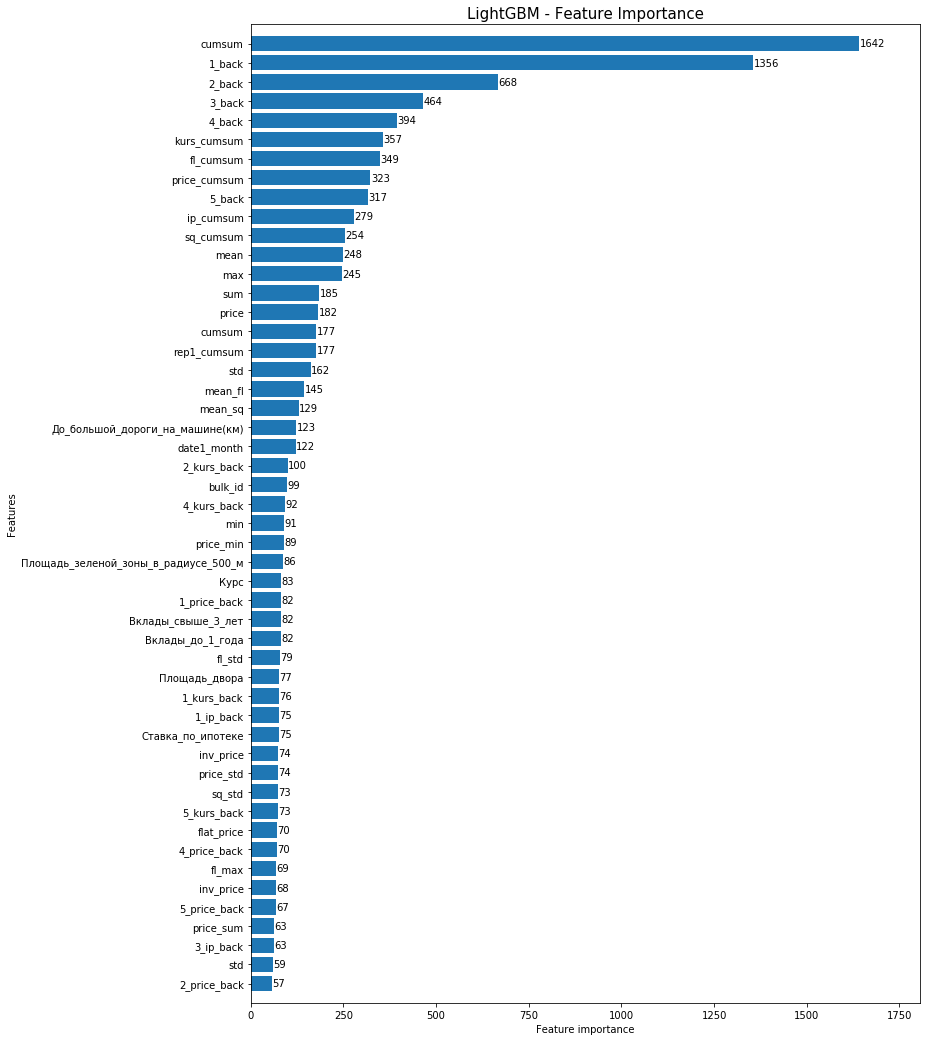

In [24]:
### Feature Importance ###
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()